# Sheet 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import pyplot as plt
%matplotlib inline

## 1 Principal Component Analysis
### (a)

In [3]:
# TODO: implement PCA (fill in the blanks in the function below)

def pca(data, n_components=None):
    """
    Principal Component Analysis on a p x N data matrix.
    
    Parameters
    ----------
    data : np.ndarray
        Data matrix of shape (p, N).
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray, np.ndarray
        the pca components (shape (n_components, p)) and the projection (shape (n_components, N))

    """
    # set n_components to p by default
    n_components = data.shape[0] if n_components is None else n_components
    assert n_components <= data.shape[0], f"Got n_components larger than dimensionality of data!"
    
    # center the data
    X_c = data - np.expand_dims(np.mean(data, axis=1), axis=-1)
    
    # compute X times X transpose
    XXT = X_c @ X_c.T
    assert XXT.shape == (data.shape[0], data.shape[0])
    
    # compute the eigenvectors and eigenvalues
    from numpy.linalg import eig 
    evalues, evectors = eig(XXT)
    
    # sort the eigenvectors by eigenvalue and take the n_components largest ones

    evalues, evectors = zip(*sorted(zip(evalues, evectors), key=lambda x: x[0], reverse=True))

    # verify that the sorting went well / indeed all eigenvectos are shape (p,)
    assert all(map(lambda x: x.shape == (data.shape[0],), evectors))
    
    # compute X_projected, the projection of the data to the components
    basis = np.array(evectors[:n_components])
    X_projected = basis @ X_c
    

    return basis, X_projected  # return the n_components first components and the pca projection of the data

# test
_, _ = pca(np.random.random(size=(100, 1000)));

In [5]:
# Example data to test your implementation 
# All the asserts on the bottom should go through if your implementation is correct

data = np.array([
    [ 1,  0,  0, -1,  0,  0],
    [ 0,  3,  0,  0, -3,  0],
    [ 0,  0,  5,  0,  0, -5]
], dtype=np.float32)

# add a random offset to all samples. it should not affect the results
data += np.random.randn(data.shape[0], 1)

n_components = 2
components, projection = pca(data, n_components=n_components)  # apply your implementation

# the correct results are known (up to some signs)
true_components = np.array([[0, 0, 1], [0, 1, 0]], dtype=np.float32)
true_projection = np.array([
    [ 0,  0,  5,  0,  0, -5],
    [ 0,  3,  0,  0, -3,  0]
], dtype=np.float32)

# check that components match, up to sign
assert isinstance(components, np.ndarray), f'Expected components to be numpy array but got {type(components)}'
assert components.shape == true_components.shape, f'{components.shape}!={true_components.shape}'
assert np.allclose(np.abs(components * true_components).sum(1), np.ones(n_components)), f'Components not matching'

# check that projections agree, taking into account potentially flipped components
assert isinstance(projection, np.ndarray), f'Expected projection to be numpy array but got {type(projection)}'
assert projection.shape == (n_components, data.shape[1]), f'Incorrect shape of projection: Expected {(n_components, data.shape[1])}, got {projection.shape}'
assert np.allclose(projection, true_projection * (components * true_components).sum(1, keepdims=True), atol=1e-6), f'Projections not matching'

print('Test successful!')

Test successful!


### (b)

Load the data (it is a subset of the data at https://opendata.cern.ch/record/4910#)

In [12]:
features = np.load('data/dijet_features.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

print(f'{features.shape=}, {labels.shape=}')  # print the shapes

# TODO: print how many samples of each class are present in the data (hint: numpy.unique)
for label in np.unique(labels).astype(int):
    print(f"Label \"{label_names[label]}\": {(labels == label).sum()} total samples.")

features.shape=(116, 2233), labels.shape=(2233,)
Label "b": 999 total samples.
Label "c": 864 total samples.
Label "q": 370 total samples.


Normalize the data

In [13]:
# TODO: report range of features and normalize the data to zero mean and unit variance
features = features / np.expand_dims(np.std(features, axis=1), axis=-1)

### (c)
Compute a 2D PCA projection and make a scatterplot of the result, once without color, once coloring the dots by label. Interpret your results.

In [14]:
# TODO: apply PCA as implemented in (a)
components, projection = pca(features, n_components=2)

Text(0.5, 1.0, 'Unlabeled scatter plot of first two principal components for dijet data')

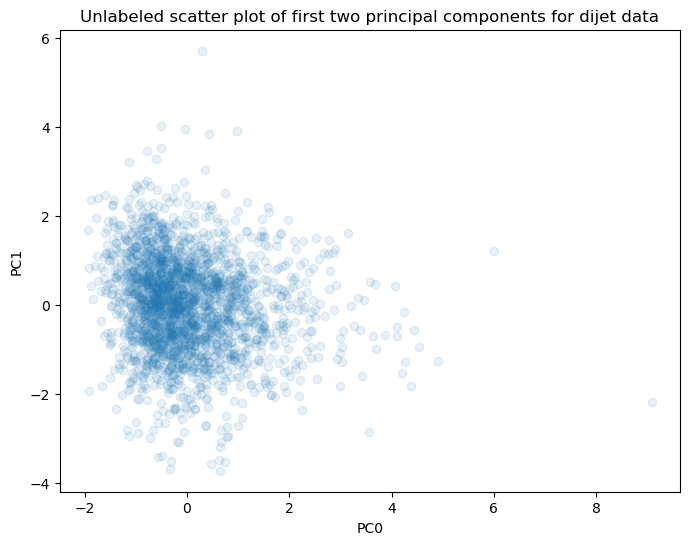

In [15]:
# TODO: make a scatterplot of the PCA projection
plt.rcParams["figure.figsize"] = 8,6
plt.scatter(*projection, alpha=0.1)
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.title("Unlabeled scatter plot of first two principal components for dijet data")

Text(0.5, 1.0, 'Labeled scatter plot of first two principal components for dijet data')

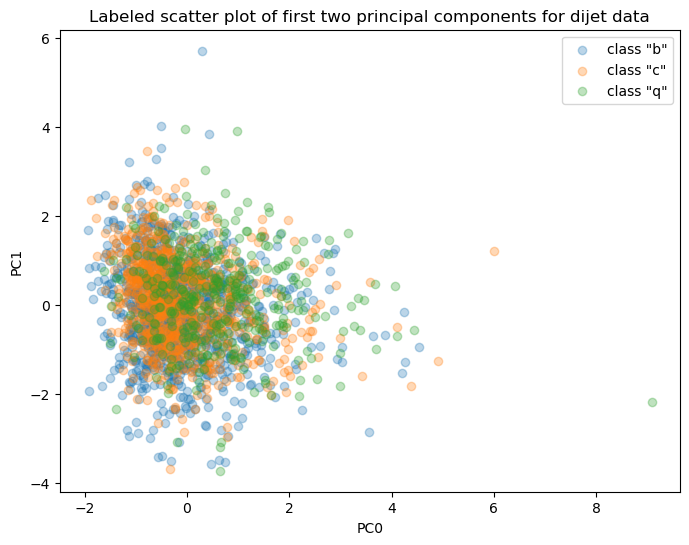

In [16]:
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels. Why could it be problematic to scatter the data sorted by labels though?)
for label in np.unique(labels).astype(int):
    mask = labels == label
    relevant_projection = projection[:, mask]
    plt.scatter(*relevant_projection, alpha=0.3, label=f"class \"{label_names[label]}\"")

plt.legend()
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.title("Labeled scatter plot of first two principal components for dijet data")

## 2 Nonlinear Dimension Reduction

In [17]:
import umap  # import umap-learn, see https://umap-learn.readthedocs.io/

In [18]:
# if you have not done 1(b) yet, you can load the normalized features directly:
features = np.load('data/dijet_features_normalized.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

### (a)

In [19]:
# TODO: Apply umap on the normalized jet features from excercise 1. It will take a couple of seconds.
# note: umap uses a different convention regarding the feature- and sample dimension, N x p instead of p x N!

n_neighbors = 2
reducer = umap.UMAP(n_components=n_neighbors)

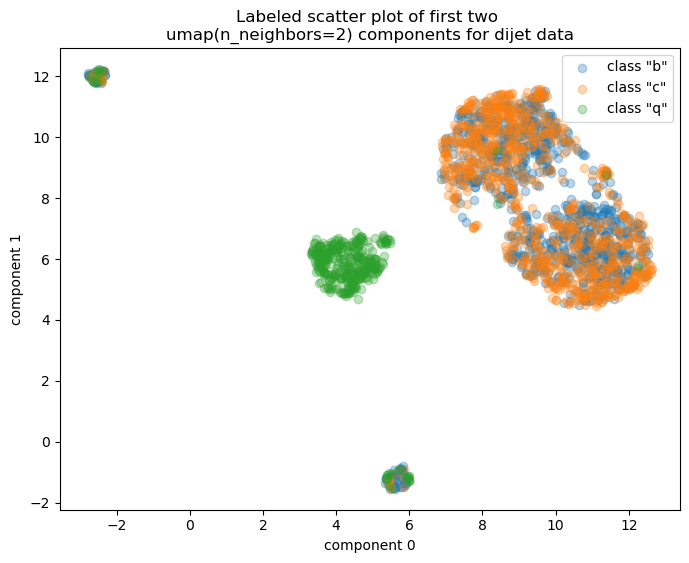

In [20]:
# TODO: make a scatterplot of the UMAP projection
def create_scatter_plot(transformed_features, title=None):
    for label in np.unique(labels).astype(int):
        mask = labels == label
        relevant_projection = projection[:, mask]
        plt.scatter(*relevant_projection, alpha=0.3, label=f"class \"{label_names[label]}\"")
    plt.legend()
    plt.xlabel("component 0")
    plt.ylabel("component 1")
    plt.title(title if title else "")
projection = reducer.fit_transform(features.T, ).T
create_scatter_plot(projection, title=f"Labeled scatter plot of first two \numap(n_neighbors={n_neighbors}) components for dijet data")

### (b)

/root/miniconda3/envs/mlph/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[2.93465312e-15 2.05340802e-06 3.17304847e-06 9.69502793e-06]
not reaching the requested tolerance 4.664063453674316e-06.
Use iteration 1955 instead with accuracy 
2.2299514031715795e-06.

  _, diffusion_map = lobpcg(
/root/miniconda3/envs/mlph/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[4.95009064e-15 1.32157027e-06 2.49654518e-06 5.10660318e-06]
not reaching the requested tolerance 4.664063453674316e-06.
  _, diffusion_map = lobpcg(
/root/miniconda3/envs/mlph/lib/python3.9/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/root/miniconda3/envs/mlph/

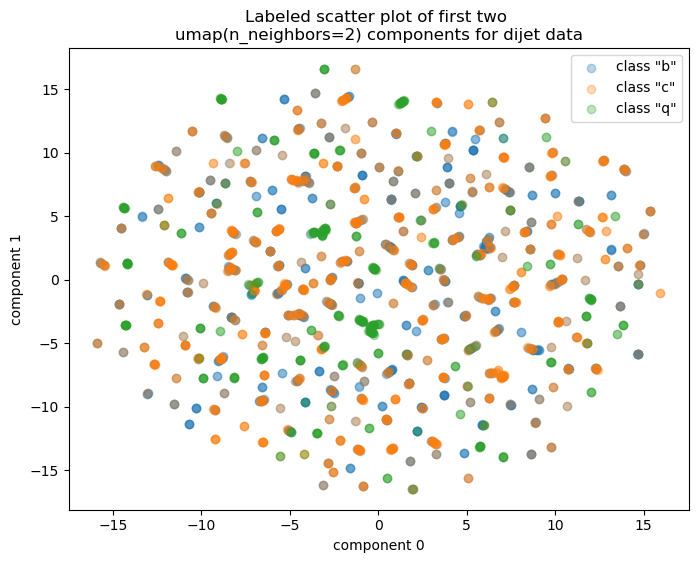

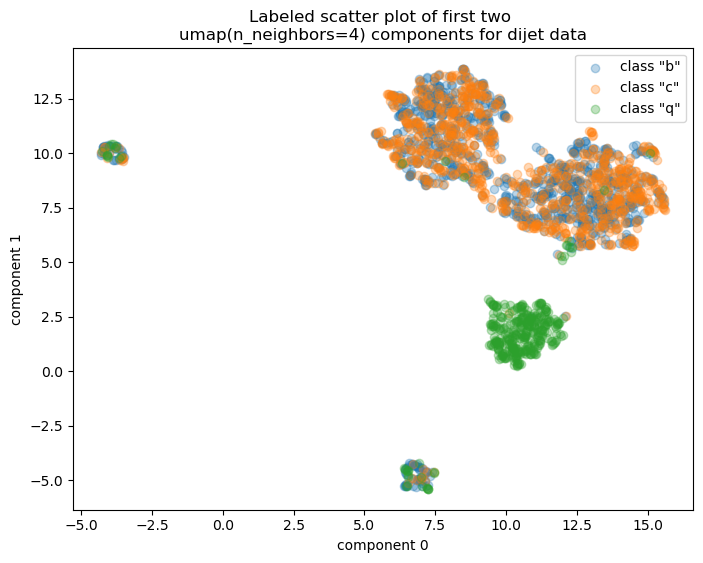

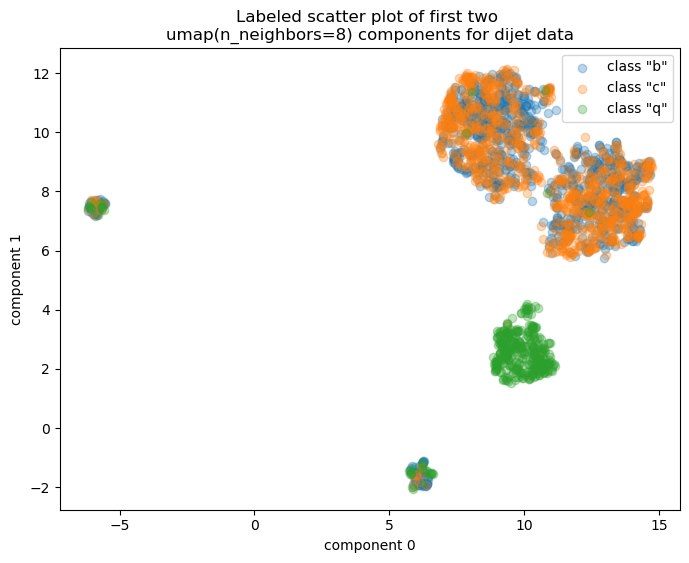

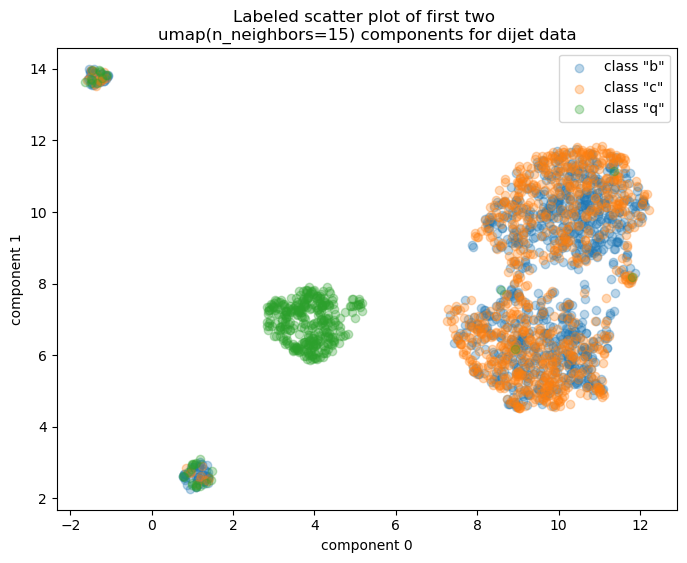

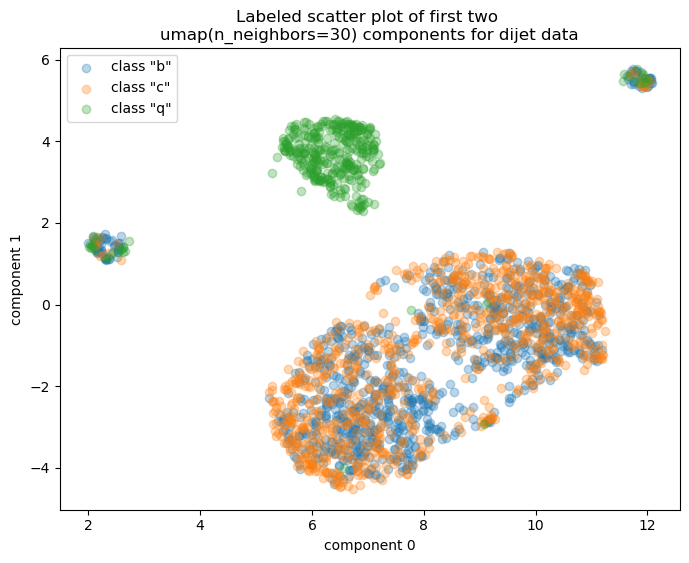

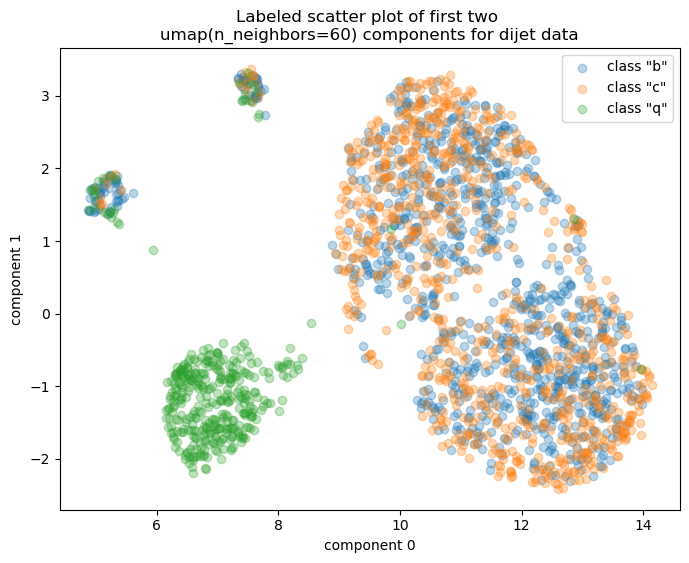

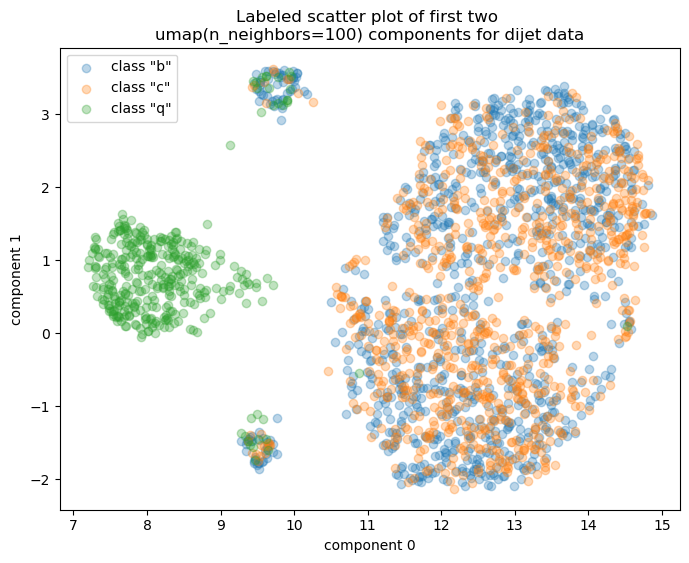

In [21]:
for n_neighbors in (2, 4, 8, 15, 30, 60, 100):
    # TODO: repeat the above, varying the n_neighbors parameter of UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    projection = reducer.fit_transform(features.T, ).T
    create_scatter_plot(projection, title=f"Labeled scatter plot of first two \numap(n_neighbors={n_neighbors}) components for dijet data")
    plt.show()